In [1]:
%load_ext autoreload
%autoreload 2

from pcurve import PrincipalCurve
import numpy as np
from matplotlib import pyplot as plt

(100, 2) (3, 2)
i 0
nseg 2 ncols 2
x (100, 2) s (3, 2)


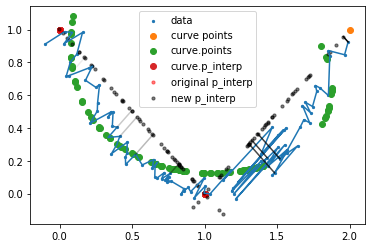

In [34]:
t = np.random.uniform(-1, 1, 100)
x = np.stack([t, t**2], axis=1) + np.random.normal(0, 0.05, (100, 2))
x[:, 0] += 1
plt.scatter(x[:, 0], x[:, 1], s=5, label='data')
s = np.array([[0, 1, 2], [1, 0, 1]]).T
print(x.shape, s.shape)
plt.scatter(s[:, 0], s[:, 1], label='curve points')

# Try original
curve = PrincipalCurve(k=3)
curve.fit(x, p=s, max_iter=1)
plt.scatter(curve.points[:, 0], curve.points[:, 1], label='curve.points')
p_interp = curve.points_interp
plt.scatter(p_interp[:, 0], p_interp[:, 1], label='curve.p_interp')
from scipy.interpolate import interp1d
p_interps = list()
for j in range(p_interp.shape[1]):
    interp = interp1d(curve.pseudotimes_interp, x[:, j], kind='cubic')
    p_interps.append(interp(curve.pseudotimes_interp[curve.order]))
p_interp = np.stack(p_interps, axis=1)
plt.plot(p_interp[:, 0], p_interp[:, 1])
curve, dist_ind, dist = curve._project_to_curve(x, s)
p_interp = curve.points_interp
plt.scatter(p_interp[:, 0], p_interp[:, 1], label='original p_interp', s=10, alpha=0.5, color='red')

# Try new
curve, dist_ind, dist = curve.project_to_curve(x, s)
pseudotime_interp = curve.pseudotimes_interp
p_interp = curve.points_interp
# plt.scatter(p_interp[:, 0], p_interp[:, 1], label='p_interp')
# plt.plot(curve.points[:, 0], curve.points[:, 1])
plt.scatter(p_interp[:, 0], p_interp[:, 1], label='new p_interp', s=10, alpha=0.5, color='black')

for i in range(10):
    path_from = (x[i][0], p_interp[i][0])
    path_to = (x[i][1], p_interp[i][1])
    plt.plot(path_from, path_to, c='black', alpha=pseudotime_interp[i])

plt.legend()


In [9]:
print(dist_ind.shape)

(100,)


In [28]:
diff = points[1:] - points[:-1]  # first difference
# denominator = np.power(np.linalg.norm(diff, axis=1), 2)
length = np.square(diff).sum(axis=1)
for i in range(X.shape[0]): # for each point
    z = X[i, :]  # z is the vector of the dimensions for the point
    numerator = diff.T * np.einsum('ij,ij->i', z - points[:-1], diff)  # multiply and sum along second axis
    seg_proj = (numerator / length).T  # compute parallel component
    proj_dist = (z - points[:-1]) - seg_proj  # compute perpendicular component
    dist_endpts = np.minimum(np.linalg.norm(z - points[0:-1], axis=1), np.linalg.norm(z - points[1:], axis = 1))
    dist_seg = np.maximum(np.linalg.norm(proj_dist, axis=1), dist_endpts)

    idx_min = np.argmin(dist_seg)
    q = seg_proj[idx_min]
    s_interp[i] = (np.linalg.norm(q) / np.linalg.norm(points[idx_min + 1, :] - points[idx_min, :])) * (pseudotimes[idx_min + 1] - pseudotimes[idx_min]) + pseudotimes[idx_min]
    p_interp[i] = (s_interp[i] - pseudotimes[idx_min]) * (points[idx_min + 1, :] - points[idx_min, :]) + points[idx_min, :]

    n_test = points[:-1] + seg_proj
    w = np.square(n_test - z).sum(axis=1)
    print(w)
    p_interp[i] =
    d_sq.append(np.linalg.norm(proj_dist[idx_min])**2)

SyntaxError: invalid syntax (<ipython-input-28-5c0b0725ed1f>, line 20)

(100, 2) (3, 2)


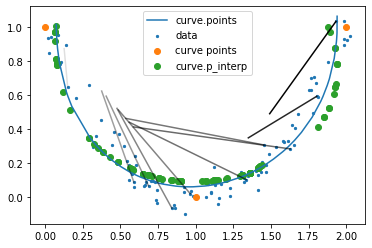

In [26]:
t = np.random.uniform(-1, 1, 100)
x = np.stack([t, t**2], axis=1) + np.random.normal(0, 0.05, (100, 2))
x[:, 0] += 1
plt.scatter(x[:, 0], x[:, 1], s=5, label='data')
s = np.array([[0, 1, 2], [1, 0, 1]]).T
print(x.shape, s.shape)
plt.scatter(s[:, 0], s[:, 1], label='curve points')
curve = PrincipalCurve(k=3)

curve.fit(x, p=s, max_iter=2)
plt.scatter(curve.points_interp[:, 0], curve.points_interp[:, 1], label='curve.p_interp')
plt.plot(curve.points[:, 0], curve.points[:, 1], label='curve.points')
s, p_interp, d = curve.project_to_curve(x, s)
# plt.scatter(p_interp[:, 0], p_interp[:, 1], label='p_interp')
# plt.plot(curve.points[:, 0], curve.points[:, 1])
for i in range(10):
    path_from = (x[i][0], p_interp[i][0])
    path_to = (x[i][1], p_interp[i][1])
    plt.plot(path_from, path_to, c='black', alpha=s[i])

plt.legend()

